# Lithology Classification using Well logs
### By Mohammad Shehar Yaar Tausif

Dataset link : https://zenodo.org/records/4351156#.YXhFTBrMJPb

In [5]:
# imports
# import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lasio
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import shap

## Reading the Dataset

In [6]:
# Training dataset
raw_df = pd.read_csv('./data/train.csv', sep=';')
#raw_df.head()

In [7]:
# Training data Rows and Columns
# print(raw_df.info())
print(f"The training dataset has {raw_df.shape[0]} rows and {raw_df.shape[1]} columns")

The training dataset has 1170511 rows and 29 columns


### Lithology Classes


In [8]:
# these values are provided by the dataset (https://thinkonward.com/app/c/challenges/force-well-logs/overview)
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

lithology_codes = list(lithology_keys.keys())

## Using Petrophysical Domain Knowledge

In [21]:
# VShale calculation
raw_df['GR_NORM'] = raw_df.groupby('WELL')['GR'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Resistivity ratio
raw_df['RES_RATIO'] = raw_df['RDEP'] / raw_df['RSHA']
# Neutron-Density separation
raw_df['ND_SEP'] = raw_df['NPHI'] - raw_df['RHOB']

### Depth Awareness

In [22]:
# Rolling features
raw_df['ROLL_GR'] = raw_df.groupby('WELL')['GR'].transform(lambda x: x.rolling(5).mean())
# Relative depth
raw_df['REL_DEPTH'] = raw_df.groupby('WELL')['DEPTH_MD'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [23]:
raw_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,GR_NORM,RES_RATIO,ND_SEP,ROLL_GR,REL_DEPTH
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,NaN,NaN,65000,1.0,0.150172,NaN,NaN,NaN,0.000000
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,NaN,NaN,65000,1.0,0.148269,NaN,NaN,NaN,0.000055
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,NaN,NaN,65000,1.0,0.139258,NaN,NaN,NaN,0.000109
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,NaN,NaN,65000,1.0,0.135315,NaN,NaN,NaN,0.000164
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,NaN,NaN,65000,1.0,0.132982,NaN,NaN,75.77876,0.000219


## Split the Training Data

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Here, X contains all features except the target and perhaps any extra fields (like confidence)
X = raw_df.drop(columns=["FORCE_2020_LITHOFACIES_LITHOLOGY", "FORCE_2020_LITHOFACIES_CONFIDENCE", "X_LOC", "Y_LOC", "WELL"])
y = raw_df["FORCE_2020_LITHOFACIES_LITHOLOGY"]

# Encode the target variable to sequential integers starting at 0
le = LabelEncoder()
le.fit(lithology_codes)
y_encoded = le.transform(y)

# First split: training (70%) and temporary (30% for validation + test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

## Data Preprocessing

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Pipeline for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # ('imputer', KNNImputer(n_neighbors=5)),
])

# Pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## XGBoost

In [27]:
from xgboost import XGBClassifier

# evaluation set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

# Create a complete pipeline that preprocesses data and then fits the XGBoost model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, device='cuda', eval_metric=["merror","mlogloss"]))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train, classifier__eval_set=eval_set, classifier__verbose=True)

[0]	validation_0-merror:0.20702	validation_0-mlogloss:1.47192	validation_1-merror:0.20838	validation_1-mlogloss:1.47438
[1]	validation_0-merror:0.18523	validation_0-mlogloss:1.18189	validation_1-merror:0.18636	validation_1-mlogloss:1.18485
[2]	validation_0-merror:0.17600	validation_0-mlogloss:0.99727	validation_1-merror:0.17752	validation_1-mlogloss:1.00117
[3]	validation_0-merror:0.17015	validation_0-mlogloss:0.86710	validation_1-merror:0.17200	validation_1-mlogloss:0.87193
[4]	validation_0-merror:0.16451	validation_0-mlogloss:0.76902	validation_1-merror:0.16662	validation_1-mlogloss:0.77443
[5]	validation_0-merror:0.15982	validation_0-mlogloss:0.69386	validation_1-merror:0.16240	validation_1-mlogloss:0.69967
[6]	validation_0-merror:0.15606	validation_0-mlogloss:0.63764	validation_1-merror:0.15875	validation_1-mlogloss:0.64381
[7]	validation_0-merror:0.15266	validation_0-mlogloss:0.59385	validation_1-merror:0.15513	validation_1-mlogloss:0.60044
[8]	validation_0-merror:0.14946	validati

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['DEPTH_MD', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR',
       'SGR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO', 'GR_NORM', 'RES_RATIO', 'ND_SEP',
       'ROLL_GR', 'REL_DEPTH'],
      dtype='object')),
                                                 ('c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Save the Pipeline

In [28]:
import joblib
joblib.dump(pipeline, 'xgboost_pipeline_mtp.joblib')

['xgboost_pipeline_mtp.joblib']

## Evaluation

### Classification Error and Log Loss

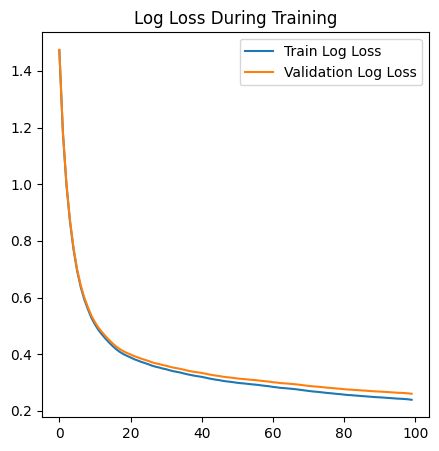

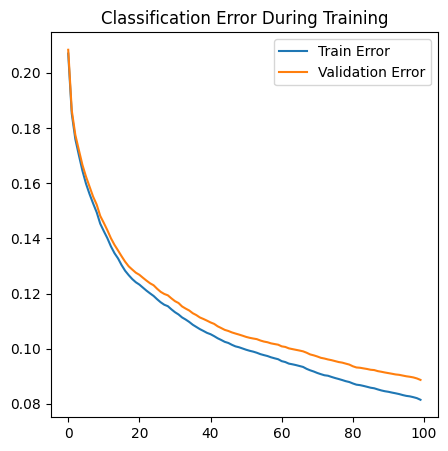

In [29]:
# Get evaluation results
results = pipeline[1].evals_result()

# Plot log loss
plt.figure(figsize=(5, 5))
plt.plot(results["validation_0"]["mlogloss"], label="Train Log Loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation Log Loss")
plt.title("Log Loss During Training")
plt.legend()
plt.show()

# Plot classification error (1 - accuracy)
plt.figure(figsize=(5, 5))
plt.plot(results["validation_0"]["merror"], label="Train Error")
plt.plot(results["validation_1"]["merror"], label="Validation Error")
plt.title("Classification Error During Training")
plt.legend()
plt.show()

### F1 Score and Confusion Matrix

/home/wazir/workspace/mtp/Force-2020-Machine-Learning-competition/sheharyaar/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:52:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Weighted F1-score: 0.9090550490350908


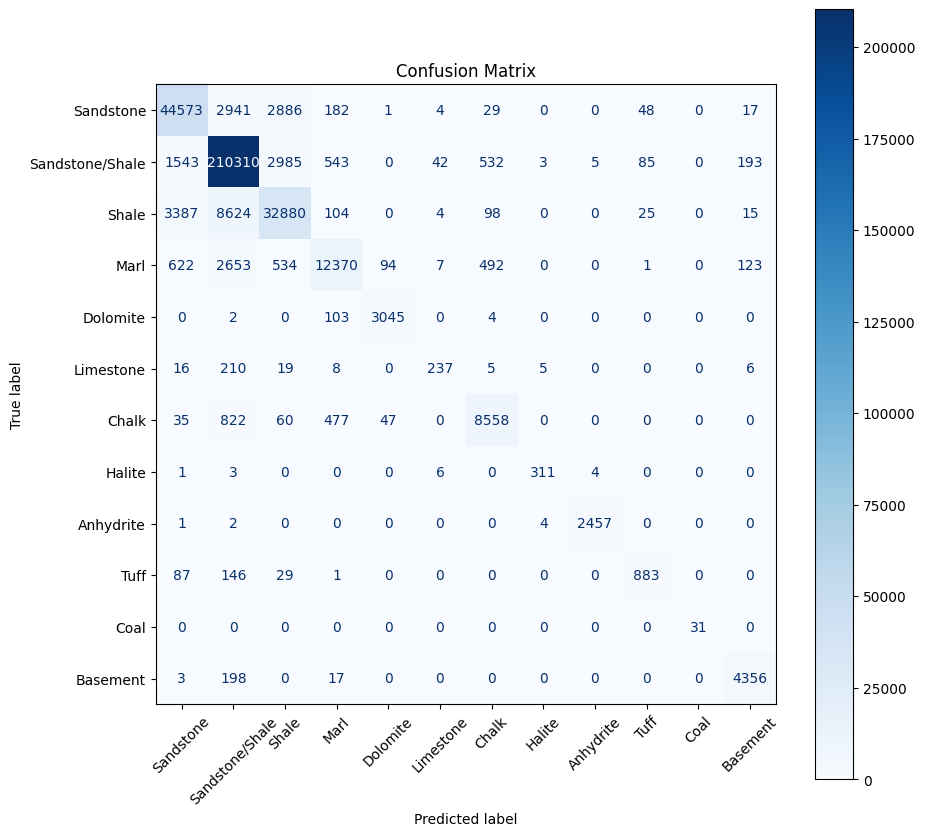

In [30]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred = pipeline.predict(X_test)

display_labels = list(lithology_keys.values())

# Calculate and print the F1-score (weighted average in case of imbalanced classes)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1-score:", f1)

# Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

### Classfication Report

In [31]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=display_labels))

Classification Report:
                 precision    recall  f1-score   support

      Sandstone       0.89      0.88      0.88     50681
Sandstone/Shale       0.93      0.97      0.95    216241
          Shale       0.83      0.73      0.78     45137
           Marl       0.90      0.73      0.81     16896
       Dolomite       0.96      0.97      0.96      3154
      Limestone       0.79      0.47      0.59       506
          Chalk       0.88      0.86      0.87      9999
         Halite       0.96      0.96      0.96       325
      Anhydrite       1.00      1.00      1.00      2464
           Tuff       0.85      0.77      0.81      1146
           Coal       1.00      1.00      1.00        31
       Basement       0.92      0.95      0.94      4574

       accuracy                           0.91    351154
      macro avg       0.91      0.86      0.88    351154
   weighted avg       0.91      0.91      0.91    351154



### Decision Tree

In [32]:
# Print a textual dump of a part of the decision tree
# Extract the underlying booster from the classifier
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
booster = pipeline.named_steps['classifier'].get_booster()
booster.feature_names = feature_names.tolist()

# Get the textual dump for the first tree in the ensemble
tree_dump = booster.get_dump()[0]
print("Decision Tree Dump (first tree):")
print(tree_dump)

Decision Tree Dump (first tree):
0:[num__GR<46.3222694] yes=1,no=2,missing=2
	1:[cat__GROUP_SHETLAND GP.<-9.99999975e-06] yes=3,no=4,missing=3
		3:[num__CALI<12.183816] yes=7,no=8,missing=8
			7:[num__NPHI<0.37919274] yes=15,no=16,missing=16
				15:[cat__GROUP_ZECHSTEIN GP.<-9.99999975e-06] yes=31,no=32,missing=31
					31:[cat__GROUP_CROMER KNOLL GP.<-9.99999975e-06] yes=63,no=64,missing=63
						63:leaf=1.49651837
						64:leaf=0.439245254
					32:[num__DEPTH_MD<2087.25708] yes=65,no=66,missing=66
						65:leaf=0.0320284702
						66:leaf=-0.162560493
				16:[num__DEPTH_MD<1278.23999] yes=33,no=34,missing=34
					33:leaf=1.54948449
					34:[cat__FORMATION_Statfjord Fm.<-9.99999975e-06] yes=67,no=68,missing=67
						67:leaf=-0.0845573992
						68:leaf=1.33846152
			8:[cat__GROUP_NORDLAND GP.<-9.99999975e-06] yes=17,no=18,missing=17
				17:[cat__FORMATION_Heimdal Fm.<-9.99999975e-06] yes=35,no=36,missing=35
					35:[num__DCAL<0.481640458] yes=69,no=70,missing=69
						69:leaf=0.792989492

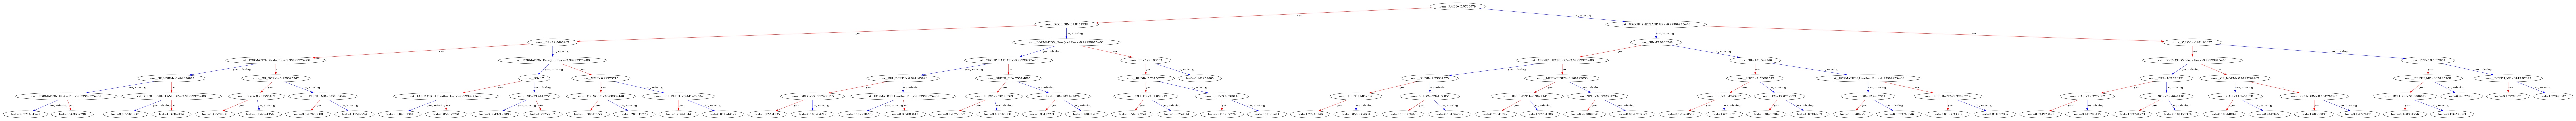

In [33]:
from xgboost import plot_tree

# plt.figure(figsize=(20, 10), dpi=000)
plot_tree(pipeline.named_steps['classifier'], num_trees=2)
# plt.title("Visualization of the first decision tree")
# plt.show()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

### SHAP Analysis

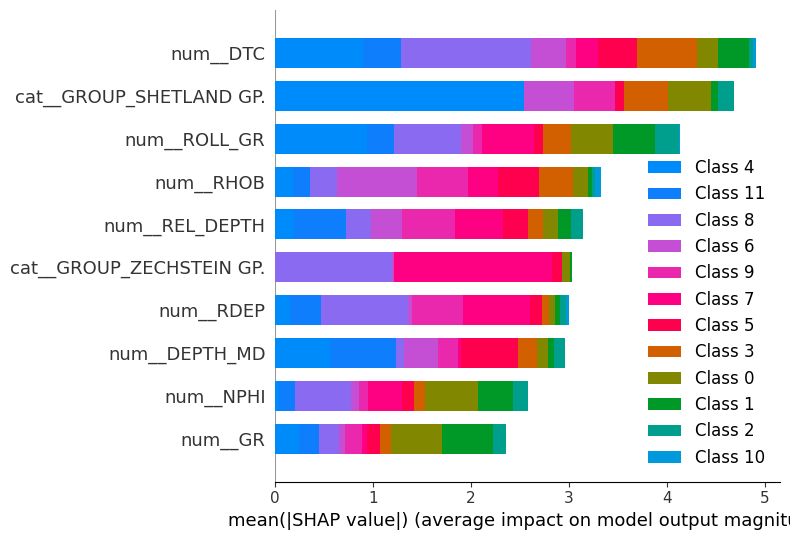

In [34]:
import shap

X_sampled = X_train.sample(100, random_state=10)
X_sampled_processed = preprocessor.transform(X_sampled)

explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_sampled_processed)

shap.summary_plot(shap_values, feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(), 
                  max_display=10,  plot_type='bar')